In [16]:
# Train the model from original scRNA-seq and SRT, take osmFISH as example.
# osm_from_scratch.json:
# {
#   "sub_name":"osm_from_scratch",
#   "real_st_path": "./data/st_osm.h5ad",
#   "real_location_path": "./data/osm_cor.txt",
#   "sc_path": "./data/sc_osm.h5ad",
#   "gpu_id": 0
# }
!/home/comp/cszrwang/anaconda3/envs/dl_transformer/bin/python main.py --input ./configs/osm_from_scratch.json

Obtain labels: 100%|####################| 50000/50000 [00:09<00:00, 5192.61it/s]
Select 33 HVGs
total real SRT for unsupervised training: 1
Generating pseudo-graphs: 100%|###############| 250/250 [00:10<00:00, 23.41it/s]
total graphs of pseudo-spots for pre-training: 250
start training seed1
Using GPU: 0
Directory already exists: ./checkpoints/osm_from_scratch
Epoch 1: 100%|#################################| 1/1 [00:00<00:00,  9.53batch/s]
average_mse_loss: 32.166
Epoch 2: 100%|#################################| 1/1 [00:00<00:00, 10.04batch/s]
average_mse_loss: 22.152
Epoch 3: 100%|#################################| 1/1 [00:00<00:00, 10.20batch/s]
average_mse_loss: 21.482
Epoch 4: 100%|#################################| 1/1 [00:00<00:00, 10.23batch/s]
average_mse_loss: 25.106
Epoch 5: 100%|#################################| 1/1 [00:00<00:00,  9.27batch/s]
average_mse_loss: 25.205
Epoch 6: 100%|#################################| 1/1 [00:00<00:00,  9.57batch/s]
average_mse_loss: 25.006
E

In [17]:
# specify which seed and epoch the pre-trained model has.
!/home/comp/cszrwang/anaconda3/envs/dl_transformer/bin/python test.py --input ./configs/osm_from_scratch.json --seed 1 --epoch 20

Obtain cell types label referring to ./pseudo_spots_tmp.h5ad
Select 33 HVGs
Directory already exists: ./outputs/osm_from_scratch
Directory already exists: ./figures/osm_from_scratch
Plotting heatmaps...
Figure(600x800)
Figure(600x800)
Figure(600x800)
Figure(600x800)
Figure(600x800)
Figure(600x800)
Figure(600x800)
Figure(600x800)
Figure(600x800)
Figure(600x800)
Figure(600x800)
Plotting pie charts...
Plotting pie plots:: 100%|####################| 737/737 [00:44<00:00, 16.40it/s]
Figure(996.667x945)


In [18]:
import sys
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rcParams
import pandas as pd
import scanpy as sc
import numpy as np
from scipy.spatial.distance import jensenshannon
from scipy.stats import pearsonr,ttest_ind,mannwhitneyu
from sklearn.metrics import mean_squared_error

In [19]:
import matplotlib.patches as mpatches
from tqdm.notebook import tqdm

In [20]:
gd_results = pd.read_table('/home/comp/cszrwang/data/osmfish/osmfish.cell_proportion.txt', sep = '\t', header = 0, index_col = 0)
gd_results = (gd_results.T/gd_results.sum(axis=1)).T
gd_loc = pd.read_csv('/home/comp/cszrwang/data/osmfish/osm_cor.txt',sep='\t')

In [21]:
def draw_pie(dist, xpos, ypos, size, colors, ax):

    cumsum = np.cumsum(dist)
    cumsum = cumsum/ cumsum[-1]
    pie = [0] + cumsum.tolist()
    i = 0
    for r1, r2 in zip(pie[:-1], pie[1:]):
        angles = np.linspace(2 * np.pi * r1, 2 * np.pi * r2, num=100)
        x = [0] + np.cos(angles).tolist()
        y = [0] + np.sin(angles).tolist()

        xy = np.column_stack([x, y])
        ax.scatter([xpos], [ypos], marker=xy, s=size, c=colors[i], edgecolors='none')
        i += 1

    return ax

def plot_frac_results(predict, cell_type_list, coordinates, file_name=None, point_size=1000, size_coefficient=0.0009, if_show=True, color_dict=None):
    
    coordinates.columns = ['coor_X', 'coor_Y']
    labels = cell_type_list
    if color_dict != None:
        colors = []
        for i in cell_type_list:
            colors.append(color_dict[i])
    else:
        if len(labels) <= 10:
            colors = plt.rcParams["axes.prop_cycle"].by_key()['color'][:len(labels)]
        else:
            import matplotlib
            color = plt.get_cmap('rainbow', len(labels))
            colors = []
            for x in color([range(len(labels))][0]):
                colors.append(matplotlib.colors.to_hex(x, keep_alpha=False))
    
    str_len = 0
    for item in cell_type_list:
        str_len = max(str_len, len(item))
    extend_region = str_len/15+1
    
    
    fig, ax = plt.subplots(figsize=(len(coordinates['coor_X'].unique())*point_size*size_coefficient+extend_region, len(coordinates['coor_Y'].unique())*point_size*size_coefficient))
    
    for i in tqdm(range(predict.shape[0]), desc="Plotting pie plots:"):
        ax = draw_pie(predict[i], coordinates['coor_X'].values[i], coordinates['coor_Y'].values[i], 
                                              size=point_size, ax=ax, colors=colors)
        
    for spine in ax.spines.values():
        spine.set_edgecolor('lightgrey')  # Set edge line color of all spines to grey
    
    
    patches = [mpatches.Patch(color=colors[i], label="{:s}".format(labels[i]) ) for i in range(len(colors))]
    fontsize = max(predict.shape[0]/100, 10)
    fontsize = min(fontsize, 30)
    ax.legend(handles=patches, fontsize=fontsize, bbox_to_anchor=(1, 1), loc="upper left")
    plt.axis("equal")
#     plt.edgecolors("lightgrey")
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    if file_name != None:
        plt.savefig(file_name, 
                    dpi=300, 
#                     bbox_inches='tight'
                   )
    if if_show == True:
        plt.show()
    plt.close('all')
    
    
    
def plot_scatter_by_type(predict, cell_type_list, coordinates, point_size=400, size_coefficient=0.0009, file_path=None, if_show=True):
    
    coordinates.columns = ['coor_X', 'coor_Y']
    
    for i in tqdm(range(len(cell_type_list)), desc="Plotting cell type scatter plot:"):
        
        fig, ax = plt.subplots(figsize=(len(coordinates['coor_X'].unique())*point_size*size_coefficient+1, len(coordinates['coor_Y'].unique())*point_size*size_coefficient))
        cm = plt.cm.get_cmap('Reds')
        ax = plt.scatter(coordinates['coor_X'], coordinates['coor_Y'], s=point_size, vmin=0, vmax=1, c=predict[:, i], cmap=cm)

        cbar = plt.colorbar(ax, fraction=0.05)
        labelsize = max(predict.shape[0]/100, 10)
        labelsize = min(labelsize, 30)
        cbar.ax.tick_params(labelsize=labelsize)
        plt.axis("equal")
        plt.xticks([])
        plt.yticks([])
        plt.xlim(coordinates['coor_X'].min()-0.5, coordinates['coor_X'].max()+0.5)
        plt.ylim(coordinates['coor_Y'].min()-0.5, coordinates['coor_Y'].max()+0.5)
        plt.tight_layout()
        if file_path != None:
            name = cell_type_list[i].replace('/', '_')
            plt.savefig(file_path+'/{}.jpg'.format(name), dpi=300, bbox_inches='tight')
        if if_show == True:
            plt.show()
        plt.close('all')

In [22]:
color_dict = {'L2/3 IT CTX-1': '#0a66c2', 'L4/5 IT CTX': '#83941f', 'L5 IT CTX': '#e7a33e', 'L5 NP CTX': '#f5987e',
    'L5 PT CTX': '#56687a', 'L6 CT CTX': '#004182', 'L6 IT CTX': '#44712e', 'L6b CTX': '#915907', 'Lamp5': '#b24020',
    'Sst': '#38434f', 'Vip': '#dce6f1'}

In [24]:
harmo_results = pd.read_csv("./outputs/osm_from_scratch/mean_out_osm_from_scratch_20_seed1.model.csv")
harmo_results = harmo_results.loc[:,np.unique(harmo_results.columns)].fillna(0)

In [25]:
output_dir = './'
cell_type_list = harmo_results.columns.to_list()
coordinates = gd_loc[['x', 'y']]

Plotting pie plots::   0%|          | 0/737 [00:00<?, ?it/s]

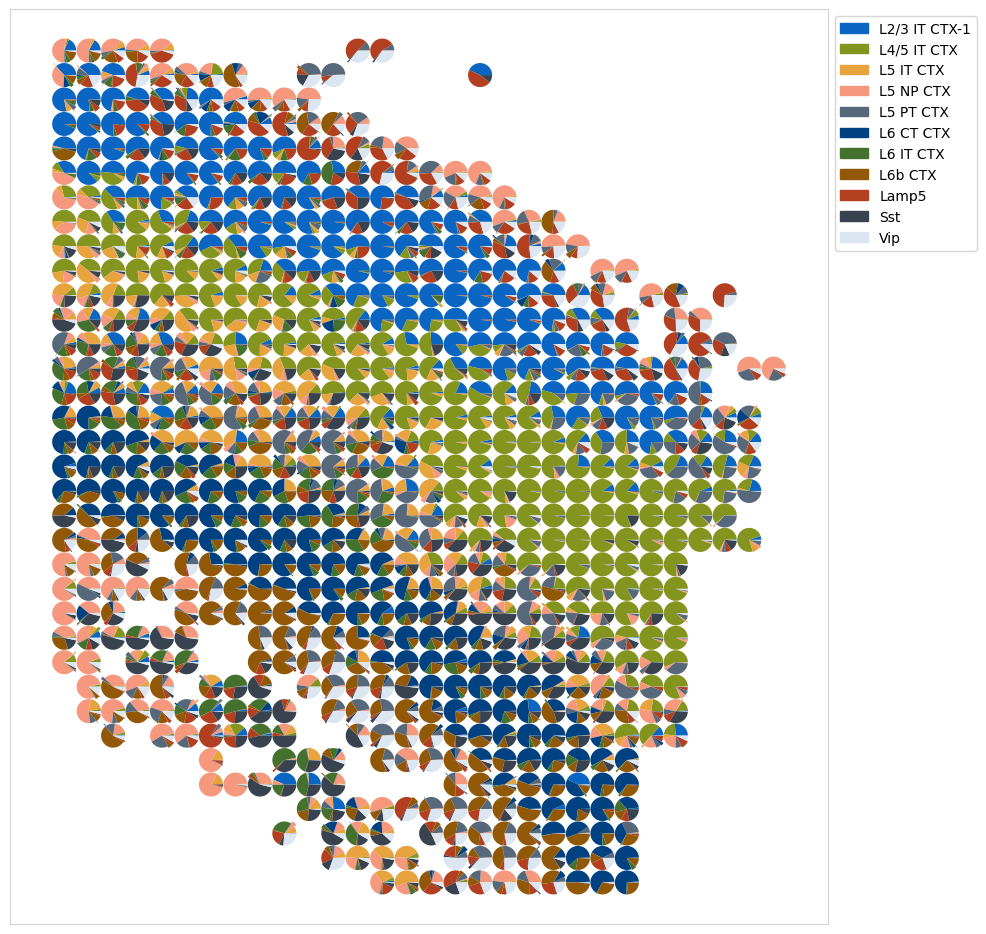

In [26]:
plot_frac_results(np.array(harmo_results), cell_type_list, coordinates, point_size=300, size_coefficient=0.0009
                  , file_name=output_dir+'/harmodecon_results_pie_plot.jpg', color_dict=color_dict)

In [27]:
gd_results = pd.read_table('/home/comp/cszrwang/data/osmfish/osmfish.cell_proportion.txt', sep = '\t', header = 0, index_col = 0)
gd_results = (gd_results.T/gd_results.sum(axis=1)).T
gd_loc = pd.read_csv('/home/comp/cszrwang/data/osmfish/osm_cor.txt',sep='\t')

Plotting pie plots::   0%|          | 0/737 [00:00<?, ?it/s]

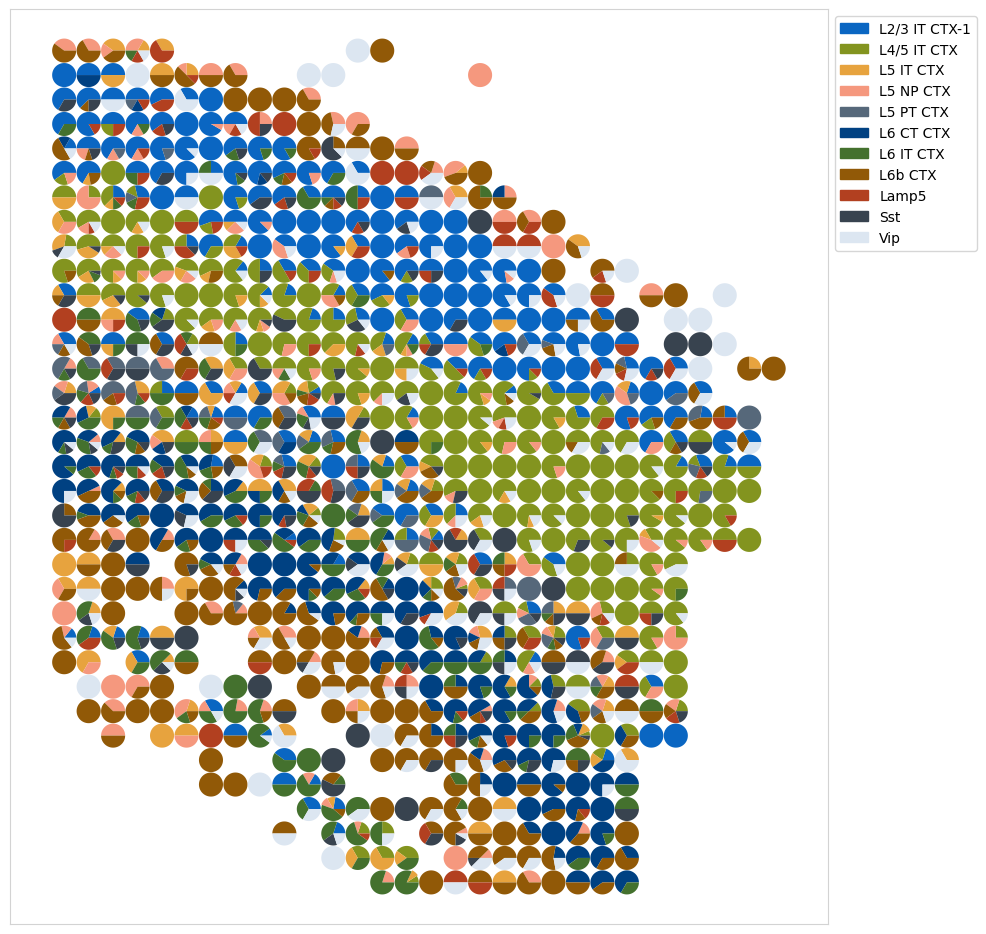

In [28]:
plot_frac_results(np.array(gd_results), cell_type_list, coordinates, point_size=300, size_coefficient=0.0009
                  , file_name=output_dir+'/gd_results_pie_plot.jpg', color_dict=color_dict)